In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from graspy.plot import pairplot
from graspy.align import SeedlessProcrustes
from graspy.align.seedless_procrustes import _sign_flip_matrix_from_int # dont do this

In [134]:
# THIS MIGHT CRASH ON OSX!!!
# in that case - you have to use wget. type this into ur terminal: 
# wget https://alyakin314.github.io/assets/X1X2-dim6/Xhat1-4960x6.csv
# wget https://alyakin314.github.io/assets/X1X2-dim6/Xhat2-4984x6.csv
# OR, to download both as a zip file
# wget https://alyakin314.github.io/assets/X1X2-dim6.zip
# then, use the lines below (might have to modify location)
# X = pd.read_csv("X1X2-dim6/Xhat1-4960x6.csv").drop(['Unnamed: 0'], axis=1).values
# Y = pd.read_csv("X1X2-dim6/Xhat2-4984x6.csv").drop(['Unnamed: 0'], axis=1).values
X = pd.read_csv("http://alyakin314.github.io/assets/X1X2-dim6/Xhat1-4960x6.csv").drop(['Unnamed: 0'], axis=1).values
Y = pd.read_csv("http://alyakin314.github.io/assets/X1X2-dim6/Xhat2-4984x6.csv").drop(['Unnamed: 0'], axis=1).values
X.shape, Y.shape

((4960, 6), (4984, 6))

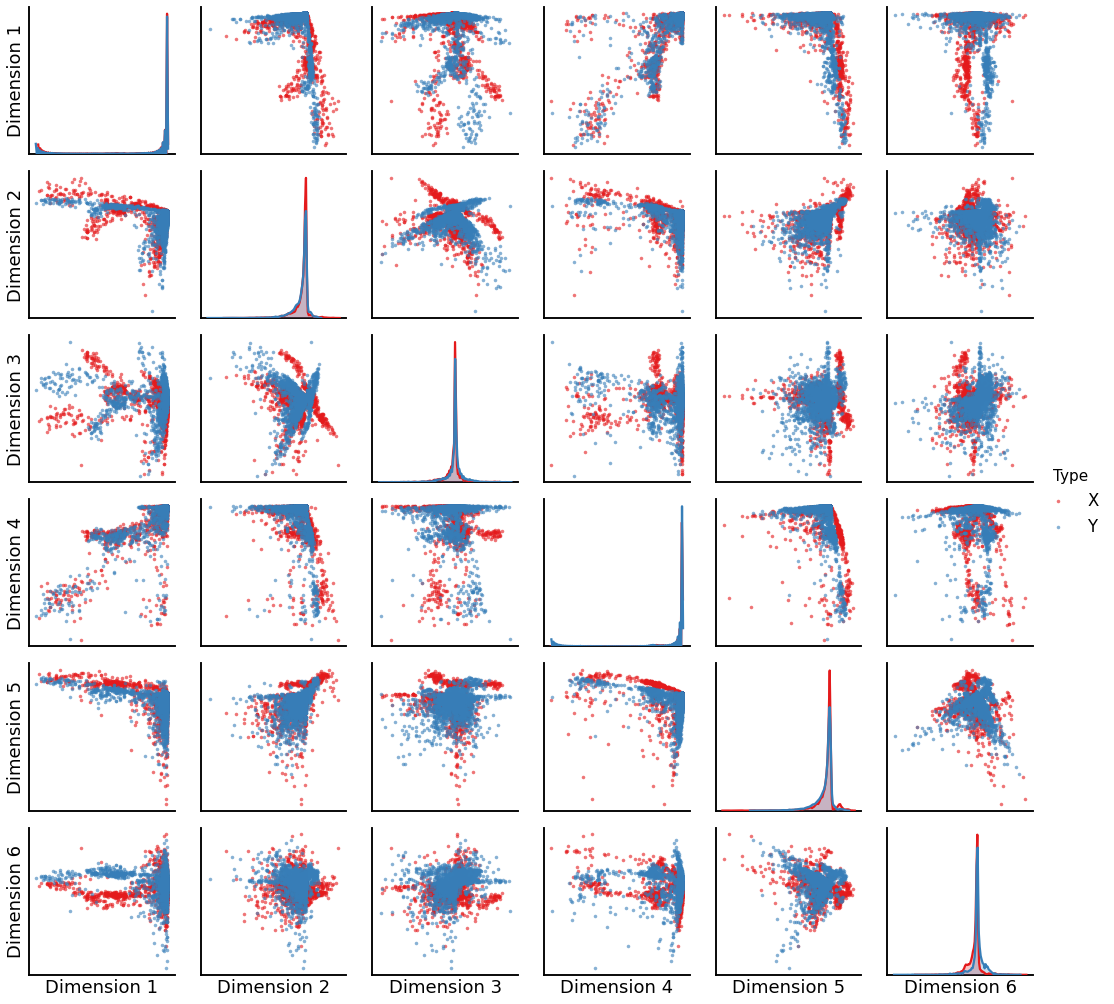

In [3]:
# plot the embeddings before any sort of alignment
pairplot(np.vstack([X, Y]), labels=['X']*4960 + ['Y']*4984, alpha=0.6)
# plt.savefig("unaligned", bbox_inches="tight", dpi=600)

In [4]:
# One does NOT need to do this. I am doing it explicitly to demonstrate the objectives.
# Instead, one can just use :
# aligner = SeedlessProcrustes(init="2d")
# aligner.fit(X, Y)
# and the aligner will try 2d initializations and pick the best one based on objective.

d=6
objectives = np.zeros(2 ** d)
for i in tqdm(range(2 ** d)):
    initial_Q = _sign_flip_matrix_from_int(i, d)
    aligner = SeedlessProcrustes(init="custom",
                                 initial_Q=initial_Q)
    objectives[i] = aligner.fit(X, Y).score_

100%|██████████| 64/64 [4:22:35<00:00, 246.18s/it]  


In [106]:
objectives

array([19.12985877, 19.1299285 , 19.12985877, 19.1299285 , 19.12992929,
       19.1299285 , 19.12992929, 19.12988672, 19.12992913, 19.12974313,
       19.12974313, 19.12974313, 19.12987199, 19.12980226, 19.12987199,
       19.12980226, 19.12985877, 19.1299285 , 19.12987883, 19.12983661,
       19.12992929, 19.12988672, 19.12991646, 19.12987874, 19.12992912,
       19.12974313, 19.12992916, 19.12974313, 19.12985877, 19.12974313,
       19.13005488, 19.13009074, 19.12992929, 19.12988672, 19.12992929,
       19.12989711, 19.13012862, 19.1300947 , 19.13012862, 19.1300947 ,
       19.12987199, 19.12980226, 19.12987199, 19.12986097, 19.13017532,
       19.13009074, 19.13013361, 19.13009074, 19.12992929, 19.12988672,
       19.12991646, 19.13003395, 19.13005489, 19.13002811, 19.13013286,
       19.13012686, 19.12987199, 19.12980226, 19.12989311, 19.12987199,
       19.130086  , 19.13009708, 19.130086  , 19.13009475])

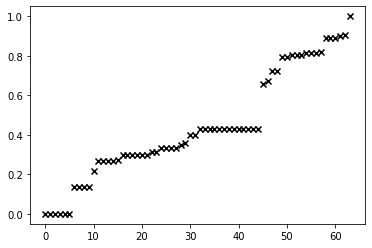

In [97]:
# plot the objectives (normalized to 0 - 1)
scaled_objectives = ((objectives - np.min(objectives)) / 
                    (np.max(objectives) - np.min(objectives)))
plt.scatter(np.arange(64), np.sort(scaled_objectives), marker='x', color='k')

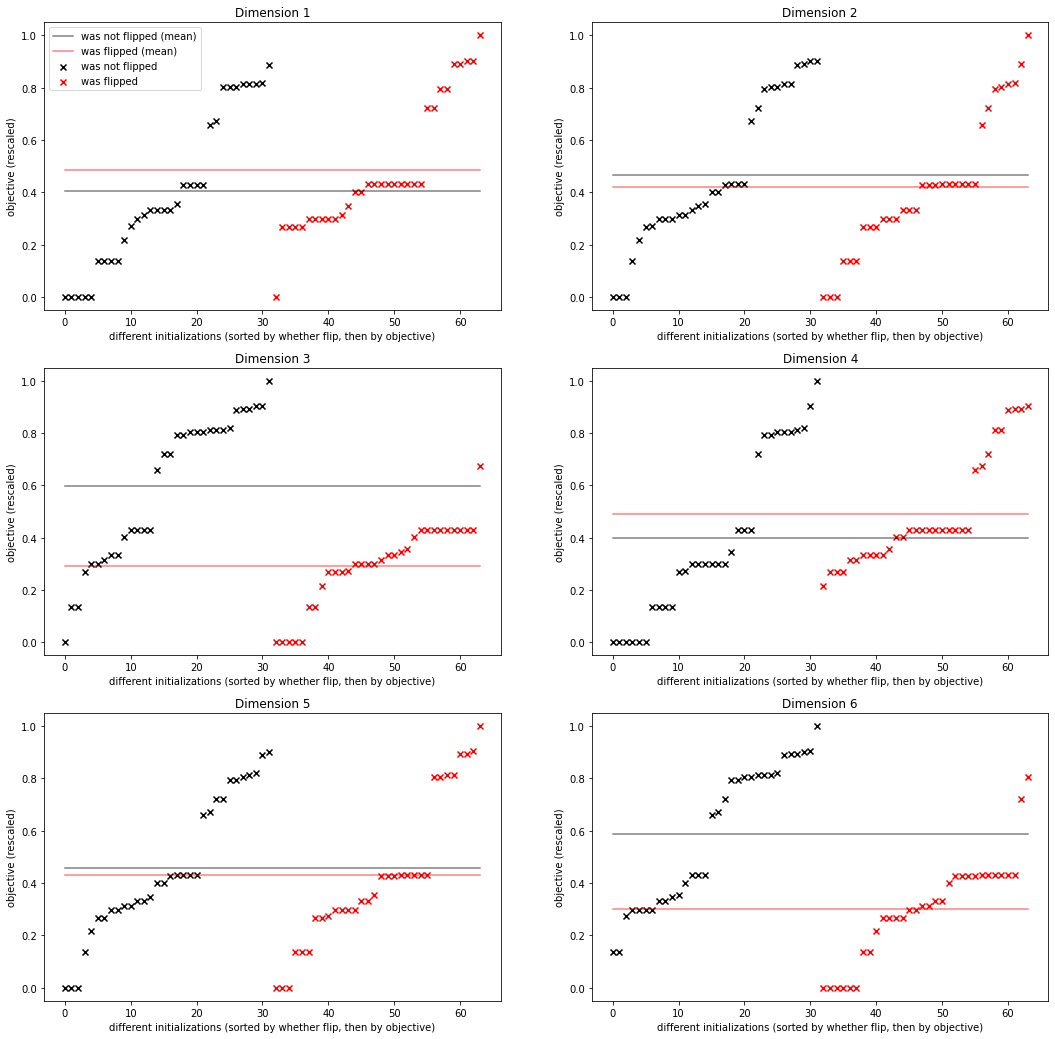

In [92]:
# a fancy plot of objectives. we clearly see that one needs to flip dimensions 3 and 6.
fig, ax = plt.subplots(3, 2, figsize=(18, 8))
for i in range(6):
    was_not_flipped = (np.arange(64) % (2*2**i) // (2**i)).astype(bool)
    # ax[i//2][i%2].scatter(np.arange(64)[was_not_flipped], 
    dont_flip = ((objectives - np.min(objectives)) / 
                (np.max(objectives) - np.min(objectives)))[was_not_flipped]
    do_flip = ((objectives - np.min(objectives)) / 
                (np.max(objectives) - np.min(objectives)))[np.logical_not(was_not_flipped)]
    ax[i//2][i%2].plot([0, 63],
                          [np.mean(dont_flip), np.mean(dont_flip)],
                           color='k',
                           label="was not flipped (mean)",
                      alpha=0.5)
    ax[i//2][i%2].plot([0, 63],
                          [np.mean(do_flip), np.mean(do_flip)],
                           color='r',
                           label="was flipped (mean)",
                      alpha=0.5)
    ax[i//2][i%2].scatter(np.arange(32),
                np.sort(dont_flip),
                marker='x', color='k',
                label="was not flipped",)
    ax[i//2][i%2].scatter(np.arange(32)+32,
                np.sort(do_flip),
                marker='x', color='r',
                label="was flipped")
    ax[i//2][i%2].set_xlabel("different initializations (sorted by whether flip, then by objective)")
    ax[i//2][i%2].set_ylabel("objective (rescaled)")
    if i == 0:
        ax[i//2][i%2].legend()
    ax[i//2][i%2].set_title(f"Dimension {i+1}")
# plt.savefig("scaled_objectives_sorted.pdf", bbox_inches="tight");

In [115]:
# now run one of the optimal objectives
i = np.argmin(objectives)
initial_Q = _sign_flip_matrix_from_int(i, d)
aligner = SeedlessProcrustes(init="custom",
                             initial_Q=initial_Q)
aligner.fit(X, Y)
X_prime = aligner.transform(X)

[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]


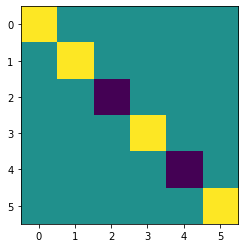

In [124]:
# the initial Q
print(initial_Q)
plt.imshow(initial_Q)

[[ 0.987  0.069  0.042  0.017 -0.108  0.081]
 [-0.074  0.794  0.597  0.051  0.025 -0.061]
 [-0.006  0.596 -0.799  0.071  0.028  0.006]
 [-0.004 -0.087  0.026  0.994  0.063 -0.006]
 [ 0.034  0.005  0.032 -0.046  0.785  0.616]
 [ 0.135 -0.046 -0.024 -0.046  0.606 -0.781]]


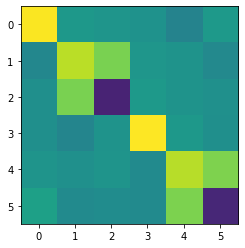

In [127]:
print(np.round(aligner.Q_, 3))
plt.imshow(aligner.Q_, vmin=-1, vmax=1)

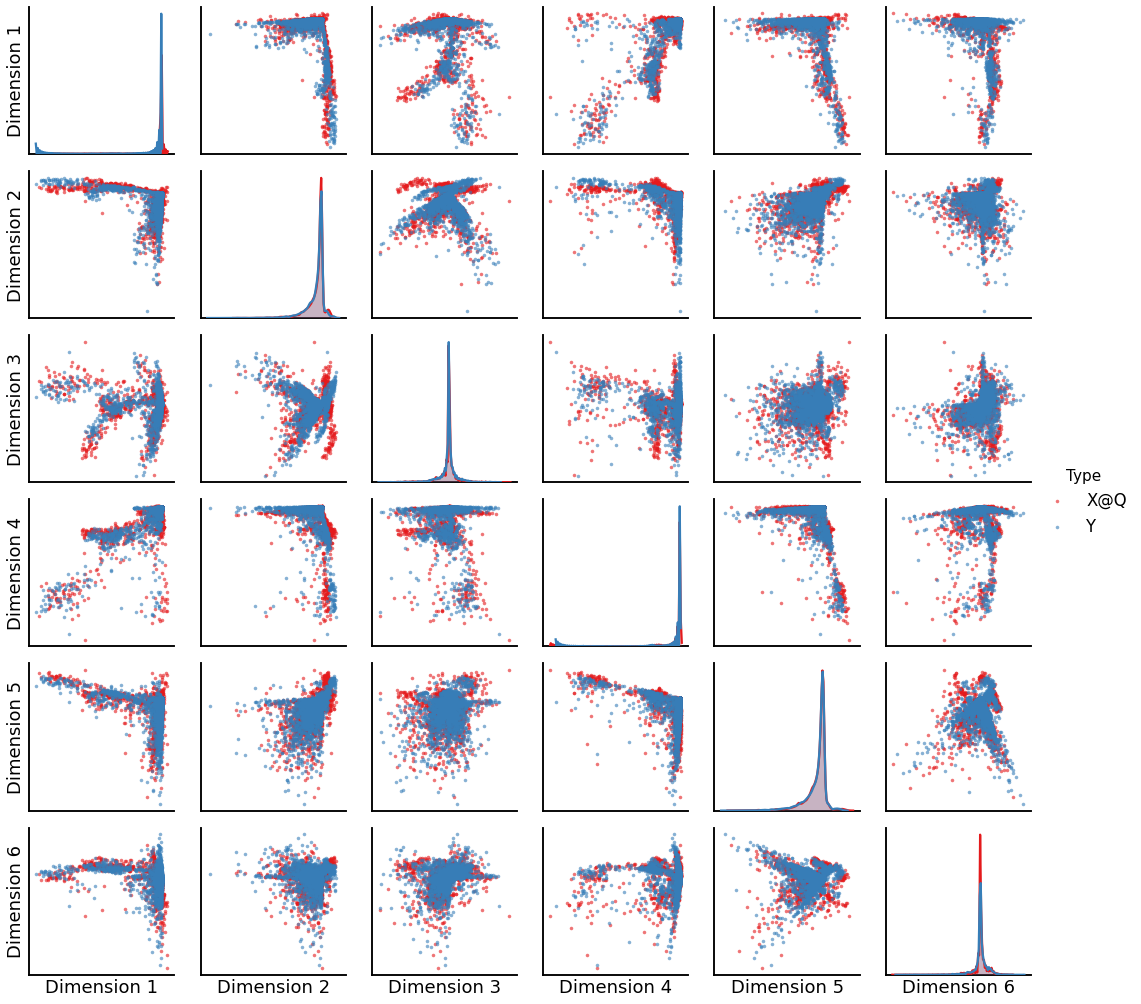

In [117]:
# plot aligneed embeddings
pairplot(np.vstack([X_prime, Y]), 
         ['X@Q']*4960  + ['Y']*4984,
         alpha=0.6)
# plt.savefig("aligned", bbox_inches="tight", dpi=600)